# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

C:\Users\MSI GF 63\miniconda3\envs\tf\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


## Read the Data

In [2]:
client_train=pd.read_csv("C:/Users/MSI GF 63/Desktop/Steg/train/client_train.csv", low_memory=False)
invoice_train=pd.read_csv("C:/Users/MSI GF 63/Desktop/Steg/train/invoice_train.csv", low_memory=False)

client_test=pd.read_csv("C:/Users/MSI GF 63/Desktop/Steg/test/client_test.csv", low_memory=False)
invoice_test=pd.read_csv("C:/Users/MSI GF 63/Desktop/Steg/test/invoice_test.csv", low_memory=False)

## Data Understanding

In [3]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [4]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [6]:
def extract_date_components_client(df, date_column):
    # Convert the date string column to pandas datetime objects with specified formats
    df[date_column] = pd.to_datetime(df[date_column], format="%d/%m/%Y" )
   
    # Modify the 'date_column' to contain the extracted year, month, and day components
    df['creation_year'] = df[date_column].dt.year
    df['creation_month'] = df[date_column].dt.month
    df['creation_day'] = df[date_column].dt.day

    # Drop the original date string column if desired
    df.drop(date_column, axis=1, inplace=True)

    return df

In [7]:
client_train = extract_date_components_client(client_train, 'creation_date')
#train = extract_date_components_invoice(train, 'invoice_date')


client_test = extract_date_components_client(client_test, 'creation_date')
#test = extract_date_components_invoice(test, 'invoice_date')

In [8]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [9]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target,creation_year,creation_month,creation_day
count,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841,2002.183552,7.278524,17.464031
std,3.354400,4.423761,104.207044,0.229614,11.565963,3.522944,8.701108
min,60.000000,11.000000,101.000000,0.000000,1977.000000,1.000000,1.000000
25%,62.000000,11.000000,103.000000,0.000000,1994.000000,4.000000,10.000000
50%,62.000000,11.000000,107.000000,0.000000,2005.000000,8.000000,18.000000
75%,69.000000,11.000000,307.000000,0.000000,2012.000000,11.000000,25.000000
max,69.000000,51.000000,399.000000,1.000000,2019.000000,12.000000,31.000000


In [10]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [11]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   disrict         135493 non-null  int64  
 1   client_id       135493 non-null  object 
 2   client_catg     135493 non-null  int64  
 3   region          135493 non-null  int64  
 4   target          135493 non-null  float64
 5   creation_year   135493 non-null  int64  
 6   creation_month  135493 non-null  int64  
 7   creation_day    135493 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 8.3+ MB


In [12]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [13]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
target - 2
creation_year - 43
creation_month - 12
creation_day - 31


In [14]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [15]:
#check for missing values
client_train.isnull().sum()

disrict           0
client_id         0
client_catg       0
region            0
target            0
creation_year     0
creation_month    0
creation_day      0
dtype: int64

No missing values in train set

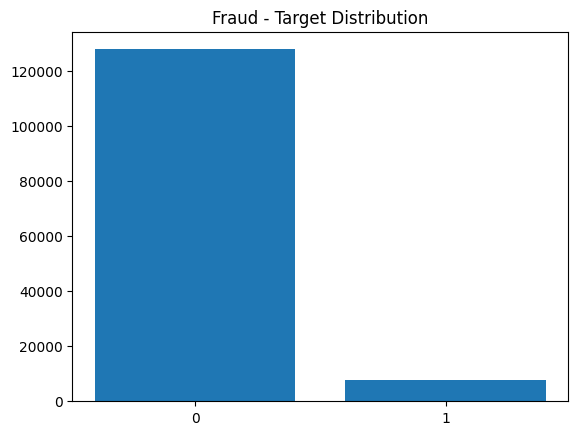

In [16]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

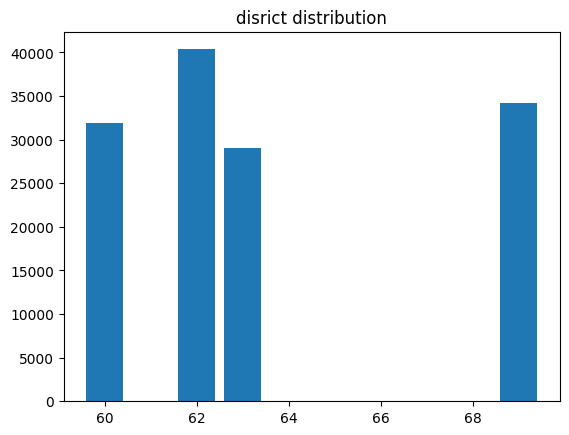

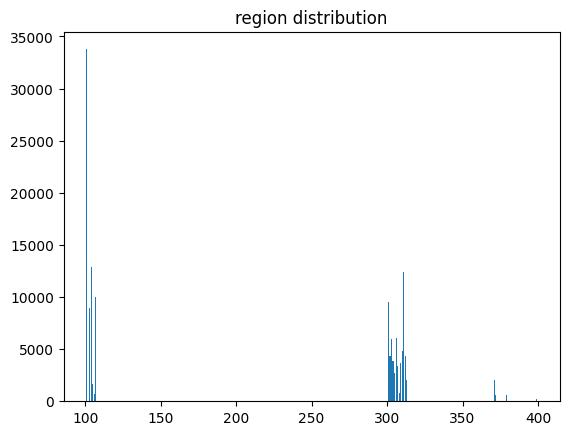

In [17]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [18]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [19]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [20]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)


In [21]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean', 'sum', 'min', 'max']
    aggs['consommation_level_2'] = ['mean', 'sum', 'min', 'max']
    aggs['consommation_level_3'] = ['mean', 'sum', 'min', 'max']
    aggs['consommation_level_4'] = ['mean', 'sum', 'min', 'max']
    aggs['reading_remarque'] = ['mean', 'min', 'max']
    aggs['counter_code'] = ['mean', 'min', 'max']
    aggs['old_index'] = ['min','max']
    aggs['new_index'] = ['min','max']



    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')


In [22]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [23]:
agg_train.head()

,client_id,1transactions_count,consommation_level_1_mean,consommation_level_1_sum,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_sum,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_sum,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_sum,consommation_level_4_min,consommation_level_4_max,reading_remarque_mean,reading_remarque_min,reading_remarque_max,counter_code_mean,counter_code_min,counter_code_max,old_index_min,old_index_max,new_index_min,new_index_max
0,train_Client_0,35,352.400000,12334,38,1200,10.571429,370,0,186,0.000000,0,0,0,0.000000,0,0,0,6.971429,6,9,203.685714,203,207,3685,16493,3809,17078
1,train_Client_1,37,557.540541,20629,190,1207,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,7.216216,6,9,203.000000,203,203,4110,23940,4661,25022
2,train_Client_10,18,798.611111,14375,188,2400,37.888889,682,0,682,0.000000,0,0,0,0.000000,0,0,0,7.055556,6,9,203.222222,203,207,25515,41532,25974,44614
3,train_Client_100,20,1.200000,24,0,15,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,6.150000,6,9,413.000000,413,413,90,99,90,114
4,train_Client_1000,14,663.714286,9292,124,800,104.857143,1468,0,400,117.357143,1643,0,800,36.714286,514,0,382,8.857143,8,9,207.000000,207,207,0,13337,959,13729


In [24]:
print(agg_train.shape)
agg_train.head()

(135493, 28)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_1_sum,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_sum,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_sum,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_sum,consommation_level_4_min,consommation_level_4_max,reading_remarque_mean,reading_remarque_min,reading_remarque_max,counter_code_mean,counter_code_min,counter_code_max,old_index_min,old_index_max,new_index_min,new_index_max
0,train_Client_0,35,352.400000,12334,38,1200,10.571429,370,0,186,0.000000,0,0,0,0.000000,0,0,0,6.971429,6,9,203.685714,203,207,3685,16493,3809,17078
1,train_Client_1,37,557.540541,20629,190,1207,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,7.216216,6,9,203.000000,203,203,4110,23940,4661,25022
2,train_Client_10,18,798.611111,14375,188,2400,37.888889,682,0,682,0.000000,0,0,0,0.000000,0,0,0,7.055556,6,9,203.222222,203,207,25515,41532,25974,44614
3,train_Client_100,20,1.200000,24,0,15,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,6.150000,6,9,413.000000,413,413,90,99,90,114
4,train_Client_1000,14,663.714286,9292,124,800,104.857143,1468,0,400,117.357143,1643,0,800,36.714286,514,0,382,8.857143,8,9,207.000000,207,207,0,13337,959,13729


In [25]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [26]:
train.head()


,disrict,client_id,client_catg,region,target,creation_year,creation_month,creation_day,1transactions_count,consommation_level_1_mean,consommation_level_1_sum,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_sum,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_sum,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_sum,consommation_level_4_min,consommation_level_4_max,reading_remarque_mean,reading_remarque_min,reading_remarque_max,counter_code_mean,counter_code_min,counter_code_max,old_index_min,old_index_max,new_index_min,new_index_max
0,60,train_Client_0,11,101,0.0,1994,12,31,35,352.400000,12334,38,1200,10.571429,370,0,186,0.000000,0,0,0,0.000000,0,0,0,6.971429,6,9,203.685714,203,207,3685,16493,3809,17078
1,69,train_Client_1,11,107,0.0,2002,5,29,37,557.540541,20629,190,1207,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,7.216216,6,9,203.000000,203,203,4110,23940,4661,25022
2,62,train_Client_10,11,301,0.0,1986,3,13,18,798.611111,14375,188,2400,37.888889,682,0,682,0.000000,0,0,0,0.000000,0,0,0,7.055556,6,9,203.222222,203,207,25515,41532,25974,44614
3,69,train_Client_100,11,105,0.0,1996,7,11,20,1.200000,24,0,15,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,6.150000,6,9,413.000000,413,413,90,99,90,114
4,62,train_Client_1000,11,303,0.0,2014,10,14,14,663.714286,9292,124,800,104.857143,1468,0,400,117.357143,1643,0,800,36.714286,514,0,382,8.857143,8,9,207.000000,207,207,0,13337,959,13729


In [27]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [28]:
train.shape, test.shape

((135493, 35), (58069, 34))

In [29]:
train.head()

,disrict,client_id,client_catg,region,target,creation_year,creation_month,creation_day,1transactions_count,consommation_level_1_mean,consommation_level_1_sum,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_sum,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_sum,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_sum,consommation_level_4_min,consommation_level_4_max,reading_remarque_mean,reading_remarque_min,reading_remarque_max,counter_code_mean,counter_code_min,counter_code_max,old_index_min,old_index_max,new_index_min,new_index_max
0,60,train_Client_0,11,101,0.0,1994,12,31,35,352.400000,12334,38,1200,10.571429,370,0,186,0.000000,0,0,0,0.000000,0,0,0,6.971429,6,9,203.685714,203,207,3685,16493,3809,17078
1,69,train_Client_1,11,107,0.0,2002,5,29,37,557.540541,20629,190,1207,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,7.216216,6,9,203.000000,203,203,4110,23940,4661,25022
2,62,train_Client_10,11,301,0.0,1986,3,13,18,798.611111,14375,188,2400,37.888889,682,0,682,0.000000,0,0,0,0.000000,0,0,0,7.055556,6,9,203.222222,203,207,25515,41532,25974,44614
3,69,train_Client_100,11,105,0.0,1996,7,11,20,1.200000,24,0,15,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,6.150000,6,9,413.000000,413,413,90,99,90,114
4,62,train_Client_1000,11,303,0.0,2014,10,14,14,663.714286,9292,124,800,104.857143,1468,0,400,117.357143,1643,0,800,36.714286,514,0,382,8.857143,8,9,207.000000,207,207,0,13337,959,13729


In [30]:
def calculate_diff_months(df, date_column='invoice_date', id_column='client_id'):
    # Convert the date string column to pandas datetime objects
    df[date_column] = pd.to_datetime(df[date_column])

    # Group by 'id_column' and calculate the difference between the maximum and minimum dates for each group
    date_diff_per_id = df.groupby(id_column)[date_column].agg(lambda x: x.max() - x.min())

    # Convert the difference to the number of months
    date_diff_per_id = date_diff_per_id.apply(lambda x: x.days)  # Convert to numeric days difference
    date_diff_per_id = date_diff_per_id / 30  # Divide by 30 to get the number of months

    # Add the new column "diff_months" to the DataFrame
    df["diff_months"] = df[id_column].map(date_diff_per_id)

    return df
invoice_train = calculate_diff_months(invoice_train, date_column='invoice_date', id_column='client_id')

columns_to_drop=['invoice_date','counter_statue','reading_remarque','counter_code','counter_coefficient','old_index','new_index']
invoice_train.drop(columns=columns_to_drop, inplace=True)
#train['index_difference'] = train['new_index_mean'] - train['old_index_mean']
invoice_train = invoice_train.drop_duplicates(subset='client_id', keep='first')
train = pd.merge(train,invoice_train, on='client_id', how='left')

In [31]:
train.head()

,disrict,client_id,client_catg,region,target,creation_year,creation_month,creation_day,1transactions_count,consommation_level_1_mean,consommation_level_1_sum,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_sum,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_sum,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_sum,consommation_level_4_min,consommation_level_4_max,reading_remarque_mean,reading_remarque_min,reading_remarque_max,counter_code_mean,counter_code_min,counter_code_max,old_index_min,old_index_max,new_index_min,new_index_max,tarif_type,counter_number,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type,diff_months
0,60,train_Client_0,11,101,0.0,1994,12,31,35,352.400000,12334,38,1200,10.571429,370,0,186,0.000000,0,0,0,0.000000,0,0,0,6.971429,6,9,203.685714,203,207,3685,16493,3809,17078,11,1335667,82,0,0,0,4,0,163.366667
1,69,train_Client_1,11,107,0.0,2002,5,29,37,557.540541,20629,190,1207,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,7.216216,6,9,203.000000,203,203,4110,23940,4661,25022,11,678902,388,0,0,0,2,0,163.766667
2,62,train_Client_10,11,301,0.0,1986,3,13,18,798.611111,14375,188,2400,37.888889,682,0,682,0.000000,0,0,0,0.000000,0,0,0,7.055556,6,9,203.222222,203,207,25515,41532,25974,44614,11,572765,407,0,0,0,4,0,164.033333
3,69,train_Client_100,11,105,0.0,1996,7,11,20,1.200000,24,0,15,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,6.150000,6,9,413.000000,413,413,90,99,90,114,11,2078,0,0,0,0,4,0,88.800000
4,62,train_Client_1000,11,303,0.0,2014,10,14,14,663.714286,9292,124,800,104.857143,1468,0,400,117.357143,1643,0,800,36.714286,514,0,382,8.857143,8,9,207.000000,207,207,0,13337,959,13729,11,19575,800,159,0,0,4,0,52.833333


In [32]:
test.head()

,disrict,client_id,client_catg,region,creation_year,creation_month,creation_day,1transactions_count,consommation_level_1_mean,consommation_level_1_sum,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_sum,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_sum,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_sum,consommation_level_4_min,consommation_level_4_max,reading_remarque_mean,reading_remarque_min,reading_remarque_max,counter_code_mean,counter_code_min,counter_code_max,old_index_min,old_index_max,new_index_min,new_index_max
0,62,test_Client_0,11,307,2002,5,28,37,488.135135,18061,0,1090,3.243243,120,0,120,0.000000,0,0,0,0.000000,0,0,0,6.810811,6,9,203.000000,203,203,3057,21348,3383,21677
1,69,test_Client_1,11,103,2009,8,6,22,1091.409091,24011,11,3600,843.136364,18549,0,4053,182.318182,4011,0,1144,586.318182,12899,0,12899,7.636364,6,9,433.000000,433,433,7,55213,800,57083
2,62,test_Client_10,11,310,2004,4,7,74,554.040541,40999,0,1200,37.364865,2765,0,400,15.743243,1165,0,800,0.162162,12,0,12,7.459459,6,9,119.648649,5,207,0,37461,41,39026
3,60,test_Client_100,11,101,1992,10,8,40,244.350000,9774,0,721,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,6.575000,6,9,104.000000,5,203,148,31354,240,31525
4,62,test_Client_1000,11,301,1977,7,21,53,568.188679,30114,0,2400,145.056604,7688,0,1362,33.679245,1785,0,1340,0.000000,0,0,0,7.905660,6,9,135.754717,5,203,0,41148,116,41215


In [33]:
import pandas as pd

# Assuming you have the functions and DataFrame 'invoice_train' defined previously

# Step 1: Calculate the diff_months and drop unnecessary columns in 'invoice_train'
invoice_test = calculate_diff_months(invoice_test, date_column='invoice_date', id_column='client_id')

columns_to_drop = ['invoice_date', 'counter_statue', 'reading_remarque', 'counter_code', 'counter_coefficient',
                   'old_index', 'new_index',]
invoice_test.drop(columns=columns_to_drop, inplace=True)

#test['index_difference'] = test['new_index_mean'] - test['old_index_mean']

# Step 3: Drop duplicates in 'invoice_train' based on 'client_id'
invoice_test = invoice_test.drop_duplicates(subset='client_id', keep='first')



In [34]:
invoice_test.head()

,client_id,tarif_type,counter_number,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type,diff_months
0,test_Client_0,11,651208,755,0,0,0,8,0,165.566667
37,test_Client_1,11,174760,800,400,180,0,4,0,124.800000
59,test_Client_10,11,799814,800,84,0,0,4,0,167.400000
133,test_Client_100,11,1064358,562,0,0,0,4,0,82.866667
173,test_Client_1000,11,8524250,860,0,0,0,4,0,171.233333


In [35]:

# Step 4: Merge 'invoice_train' with 'train' on 'client_id'
test = pd.merge(test, invoice_test, on='client_id', how='left')



In [36]:
train['totale_consommation']=train['consommation_level_1']+train['consommation_level_2']+train['consommation_level_3']+train['consommation_level_4']
test['totale_consommation']=test['consommation_level_1']+test['consommation_level_2']+test['consommation_level_3']+test['consommation_level_4']
train = pd.get_dummies(train, columns=['disrict'])
test = pd.get_dummies(test, columns=['disrict'])


In [37]:
train.shape

(135493, 48)

In [38]:
test.shape

(58069, 47)

In [39]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [40]:
train.head()

,client_catg,region,target,creation_year,creation_month,creation_day,1transactions_count,consommation_level_1_mean,consommation_level_1_sum,consommation_level_1_min,consommation_level_1_max,consommation_level_2_mean,consommation_level_2_sum,consommation_level_2_min,consommation_level_2_max,consommation_level_3_mean,consommation_level_3_sum,consommation_level_3_min,consommation_level_3_max,consommation_level_4_mean,consommation_level_4_sum,consommation_level_4_min,consommation_level_4_max,reading_remarque_mean,reading_remarque_min,reading_remarque_max,counter_code_mean,counter_code_min,counter_code_max,old_index_min,old_index_max,new_index_min,new_index_max,tarif_type,counter_number,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type,diff_months,totale_consommation,disrict_60,disrict_62,disrict_63,disrict_69
0,11,101,0.0,1994,12,31,35,352.400000,12334,38,1200,10.571429,370,0,186,0.000000,0,0,0,0.000000,0,0,0,6.971429,6,9,203.685714,203,207,3685,16493,3809,17078,11,1335667,82,0,0,0,4,0,163.366667,82,1,0,0,0
1,11,107,0.0,2002,5,29,37,557.540541,20629,190,1207,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,7.216216,6,9,203.000000,203,203,4110,23940,4661,25022,11,678902,388,0,0,0,2,0,163.766667,388,0,0,0,1
2,11,301,0.0,1986,3,13,18,798.611111,14375,188,2400,37.888889,682,0,682,0.000000,0,0,0,0.000000,0,0,0,7.055556,6,9,203.222222,203,207,25515,41532,25974,44614,11,572765,407,0,0,0,4,0,164.033333,407,0,1,0,0
3,11,105,0.0,1996,7,11,20,1.200000,24,0,15,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,6.150000,6,9,413.000000,413,413,90,99,90,114,11,2078,0,0,0,0,4,0,88.800000,0,0,0,0,1
4,11,303,0.0,2014,10,14,14,663.714286,9292,124,800,104.857143,1468,0,400,117.357143,1643,0,800,36.714286,514,0,382,8.857143,8,9,207.000000,207,207,0,13337,959,13729,11,19575,800,159,0,0,4,0,52.833333,959,0,1,0,0


# Modelling

## Train LGBM *Classifier*

In [41]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [42]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Count the number of samples for each target value (0 and 1)
counts = y_train.value_counts()

# Calculate the weight for each target value
class_weights = {0: 1.0, 1: counts[0] / counts[1]}

# Create LightGBM dataset
train_data = lgb.Dataset(x_train, label=y_train, weight=y_train.map(class_weights))

# Define LightGBM parameters
lgb_params = {
    'objective': 'regression',  # Regression task
    'boosting_type': 'gbdt',
    'metric': 'mse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 1000,
    'random_state': 40
}

# Train LightGBM model with weighted samples
model = lgb.train(lgb_params, train_data)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7661
[LightGBM] [Info] Number of data points in the train set: 135493, number of used features: 46
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Make Predictions on test set

In [43]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.342939
1,0.742117
2,0.544523
3,0.176441
4,0.441177
